# Signal-to-Noise Test

### Motivation

In this notebook we will look at how the Zernike polynomial estimation performance from the Wavefront Estimation Calculation changes as a function of the magnitude of the test star with the background noise level held constant. 

### Performance Metric
Our performance metric in this first version will be the RMS value between OPD results and the Zernike polynomials given by `ts_wep` output.

### Test Data
The test data was created on the UW *epyc* machine using `runSnrAnalysis.py` in the `ts_phosim/notebooks/analysis_scripts` directory.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append('../analysis_tools/')
from calcMetrics import calcMetrics

In [3]:
from imageTools import imageTools

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_dir = '/astro/store/epyc/projects/lsst_comm/ts_phosim/notebooks/analysis_data/signal_to_noise_test/150x150yOffset/'

In [6]:
calcMagMetrics = calcMetrics()
imTools = imageTools()

### Calc SNR

In [7]:
from astropy.wcs import WCS
from astropy import units as u
from astropy.io import fits

In [8]:
def measureSNR(im_file, star_file):
    star_cat = np.genfromtxt(star_file)
    hdulist = fits.open(im_file)
    
    w = WCS(hdulist[1].header)
    x, y = w.wcs_world2pix(np.array(star_cat[:, 1])*u.deg, np.array(star_cat[:, 2])*u.deg, 1)
    borders = np.array([[y[0] - 120, y[0] + 120], [y[0] - 120, y[0] + 120]], dtype=int)
    donut_array = hdulist[1].data[borders[1][0]:borders[1][1], borders[0][0]:borders[0][1]]
    
    x = 142 + 47*np.cos(np.arange(0, 2*np.pi, 0.05))
    y = 110 + 47*np.sin(np.arange(0, 2*np.pi, 0.05))
    
    val = []
    for xx, yy in zip(y, x):
        val.append(donut_array[int(xx), int(yy)])
        
    signal = np.median(val)
    bg = donut_array[:50, :50].flatten()
    snr = signal / np.sqrt(signal + np.median(bg))
    
    return snr

## Signal-to-Noise Test

In [9]:
mag_array = np.arange(10., 19.1, 0.5)
ssrTotalVals = []
ssrFieldVals = []
zernikeErrors = []
snr_array = []
for mag in mag_array:
    
    image_dir = os.path.join(data_dir, 'mag_%.2f_output/input/rerun/run1/postISRCCD/09006001-g/R22/' % mag)
    image_file = os.path.join(image_dir, 'postISRCCD_09006001-g-R22-S02-det092.fits')
    star_cat_file = '../analysis_scripts/starCat.txt'
    
    snr = measureSNR(image_file, star_cat_file)
    snr_array.append(snr)
    
    opdZkFilePath = os.path.join(data_dir, 'opd.zer.mag.%.1f' % (mag))
    wfsZkFilePath = os.path.join(data_dir, 'wfs.zer.mag.%.1f' % (mag))
    opdData, wfsData = calcMagMetrics.loadZernikeData(opdZkFilePath, wfsZkFilePath)
    opdData = opdData[:3]
    wfsData = wfsData[:3]
    zerFieldSSR, zerTotalSSR = calcMagMetrics.calcSSR(opdData, wfsData)
    zernikeErrors.append(np.sqrt((wfsData - opdData)**2.))
    ssrFieldVals.append(zerFieldSSR)
    ssrTotalVals.append(zerTotalSSR)
zernikeErrors = np.array(zernikeErrors)
zernikeErrors = np.transpose(zernikeErrors, axes=(2,1,0))

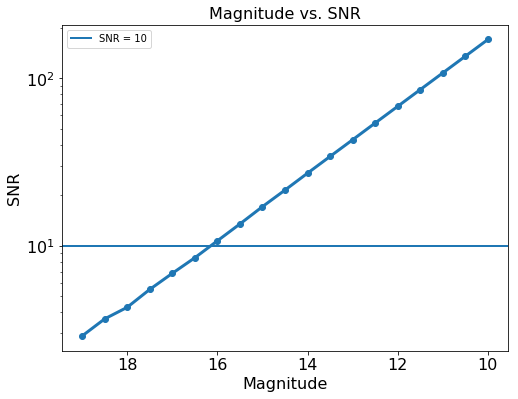

In [10]:
fig = plt.figure(figsize=(8,6))
plt.plot(mag_array, snr_array, '-o', lw=3)
plt.xlabel('Magnitude', size=16)
plt.ylabel('SNR', size=16)
plt.axhline(y=10., lw=2, label='SNR = 10')
plt.legend()
plt.gca().invert_xaxis()
plt.xticks(size=16)
plt.yticks(size=16)
plt.title('Magnitude vs. SNR', size=16)
plt.yscale('log')

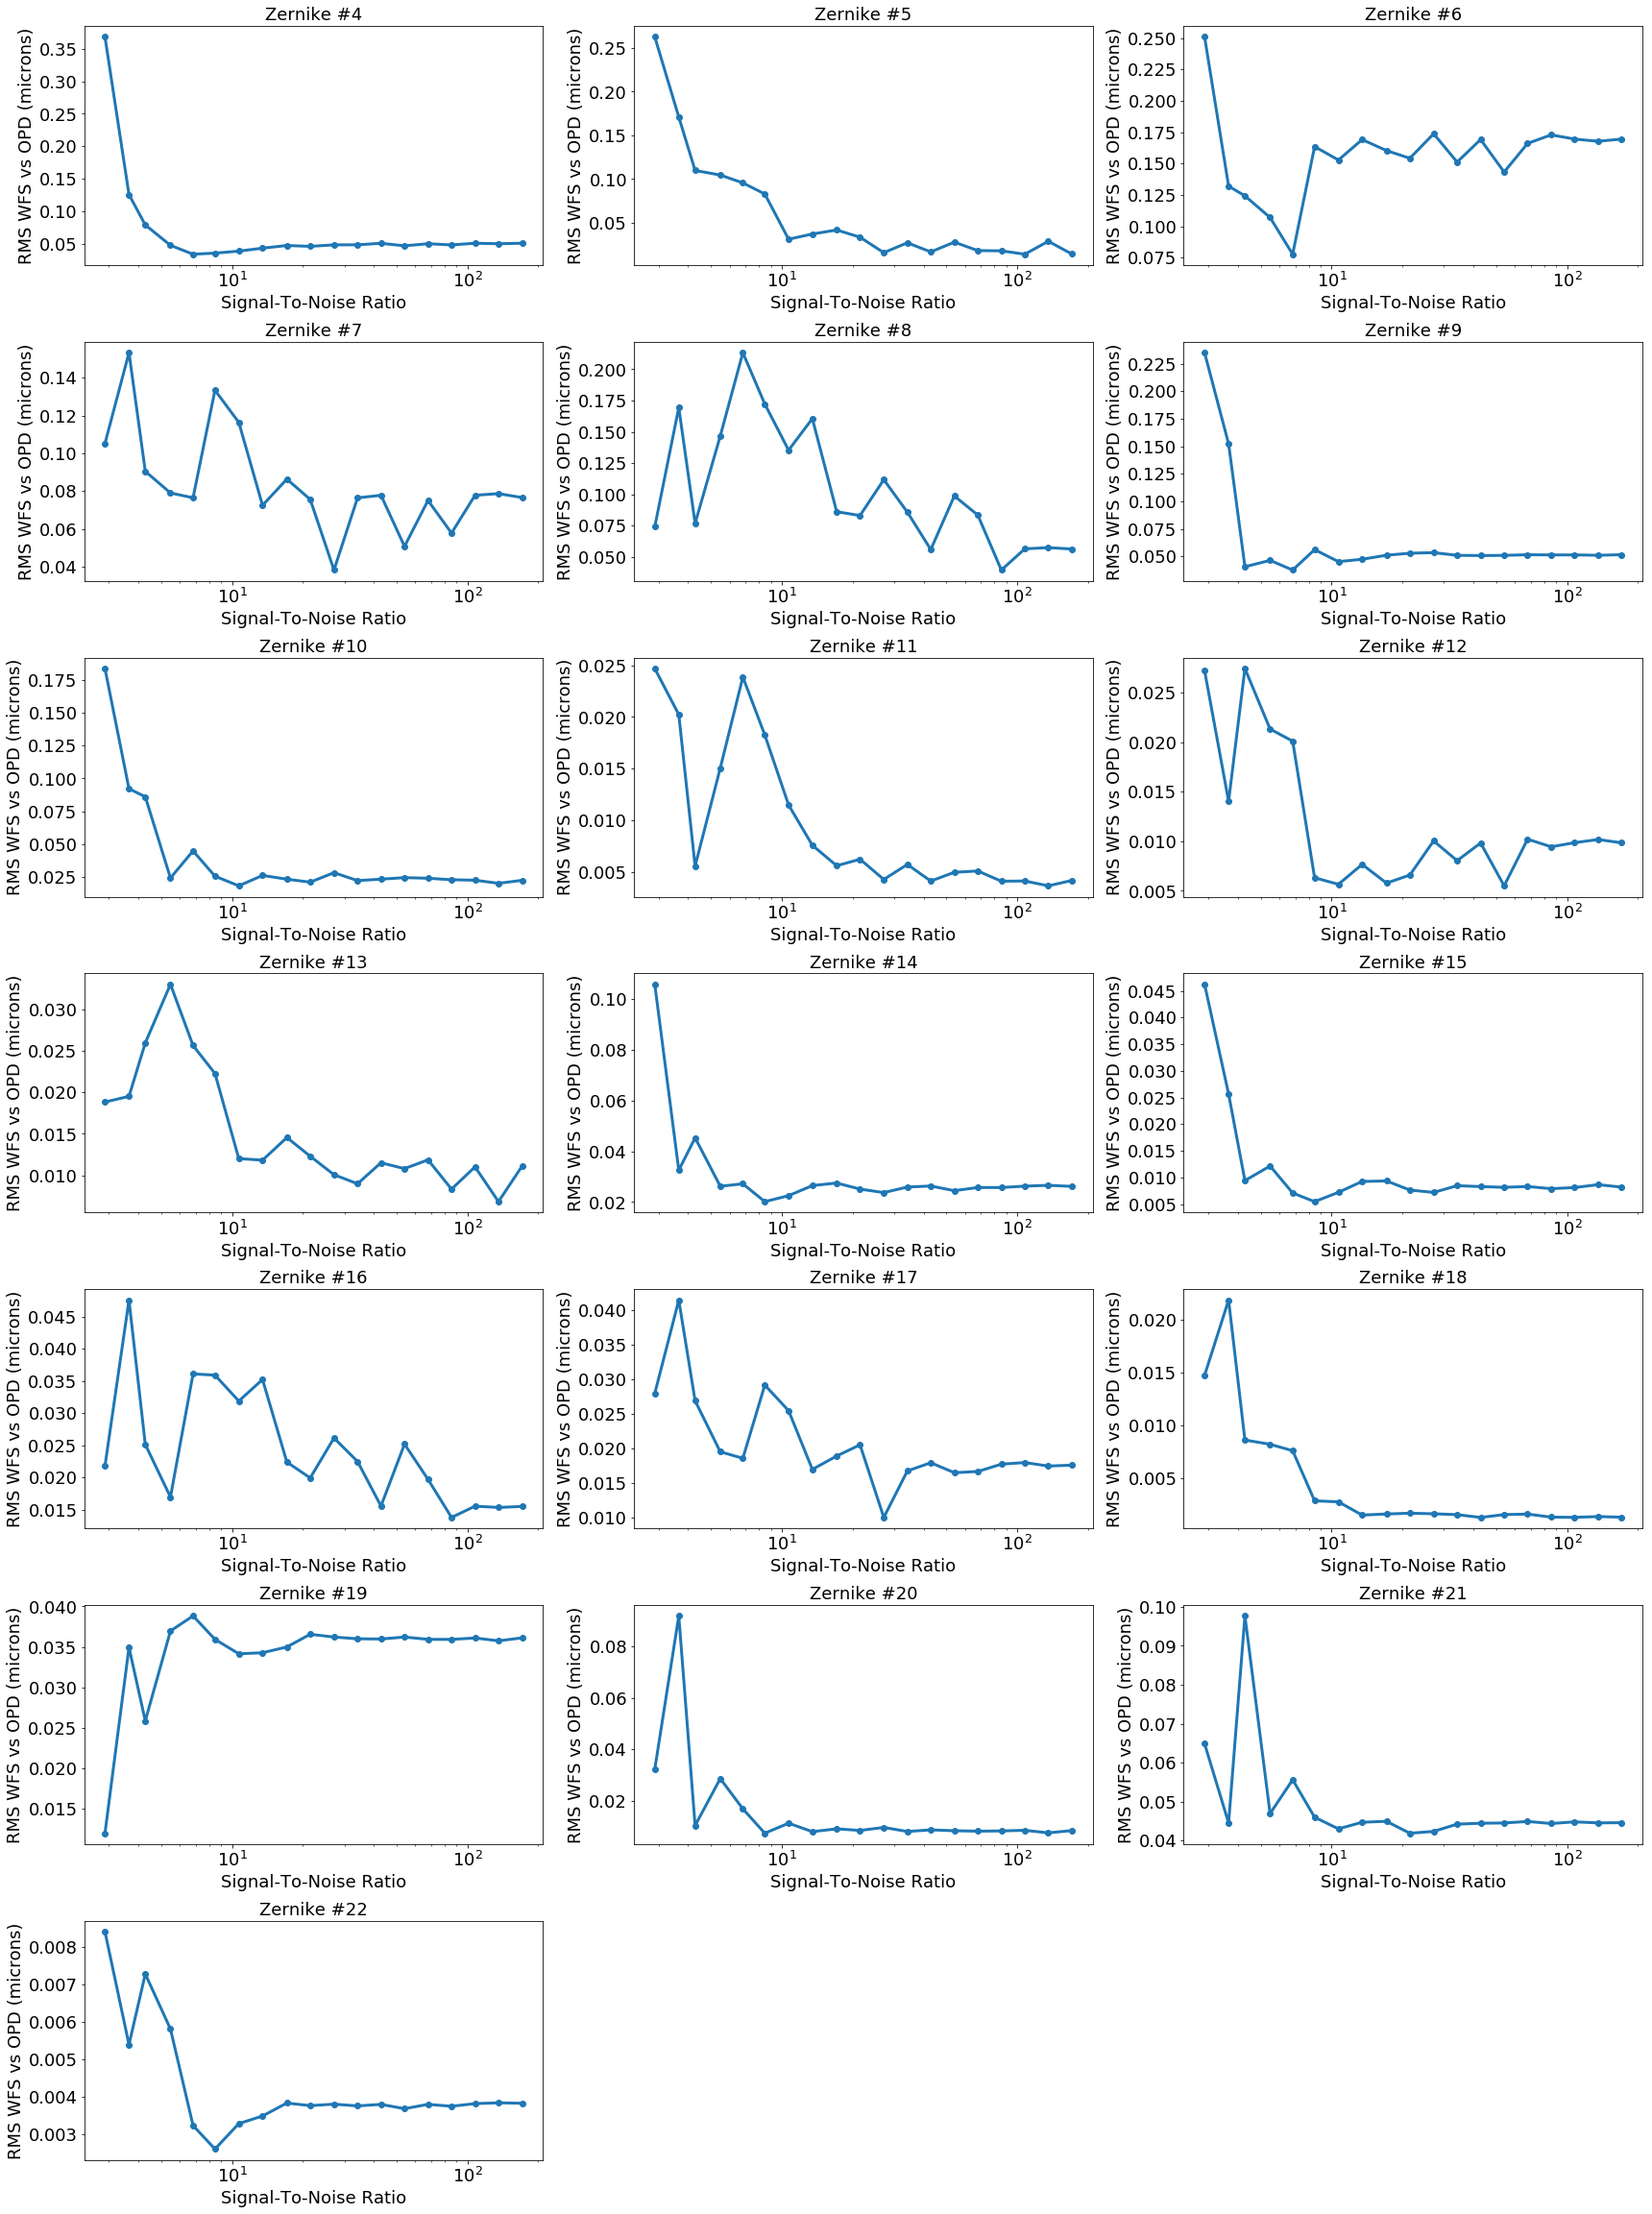

In [11]:
fig = plt.figure(figsize=(24,36))

plot_mag = False # If you'd rather plot magnitude than SNR set this to True

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    if plot_mag is True:
        plt.plot(mag_array, np.sqrt(np.mean(np.square(zernikeErrors[zernike]), axis=0)), '-o', lw=3)
        plt.xlabel('Magnitude of Star', size=18)
    else:
        plt.plot(snr_array, np.sqrt(np.mean(np.square(zernikeErrors[zernike]), axis=0)), '-o', lw=3)
        plt.xlabel('Signal-To-Noise Ratio', size=18)
        plt.xscale('log')
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    #plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

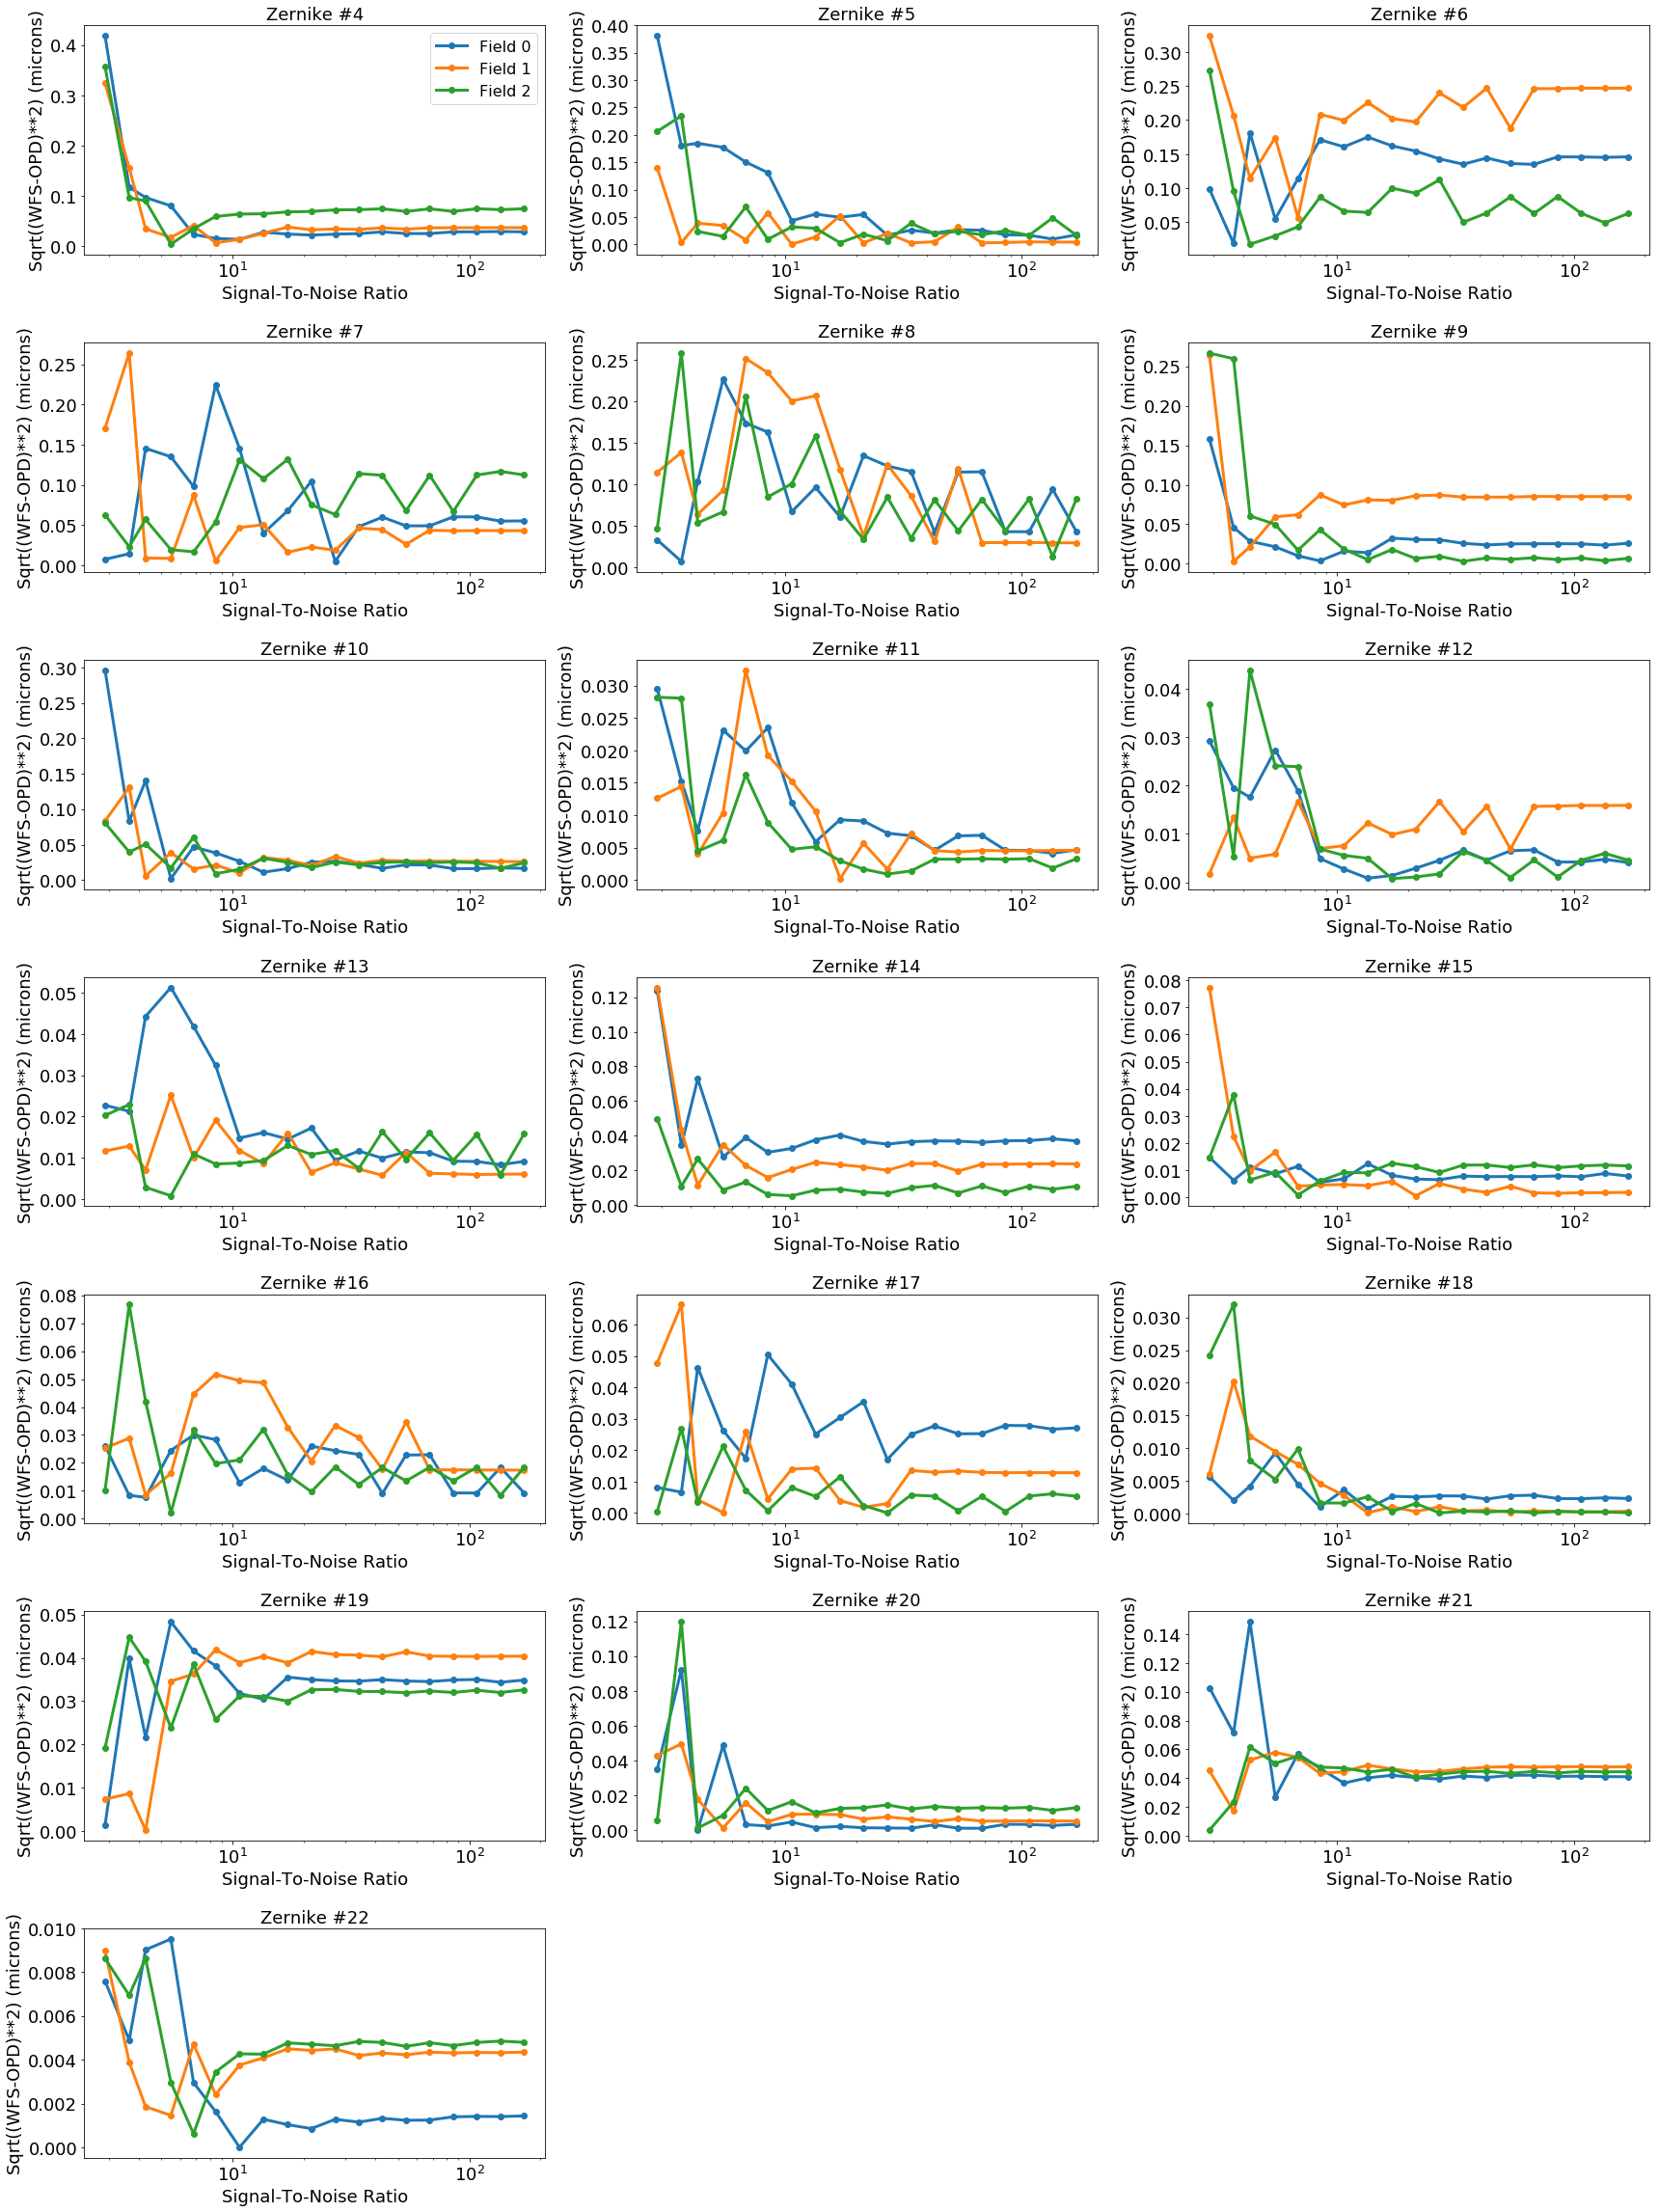

In [12]:
fig = plt.figure(figsize=(24,36))

plot_mag = False

for zernike in range(19):
    fig.add_subplot(8, 3, zernike+1)
    for ccd in range(3):
        if plot_mag is True:
            plt.plot(mag_array, zernikeErrors[zernike, ccd], '-o', lw=3, label='Field %i' % ccd)
        else:
            plt.plot(snr_array, zernikeErrors[zernike, ccd], '-o', lw=3, label='Field %i' % ccd)
    if plot_mag is True:
        plt.xlabel('Magnitude of Star', size=18)
    else:
        plt.xlabel('Signal-To-Noise Ratio', size=18)
        plt.xscale('log')
    plt.ylabel('Sqrt((WFS-OPD)**2) (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
    if zernike == 0:
        plt.legend(fontsize=16)
    plt.title('Zernike #%i' % (zernike+4), size=18)
    
plt.tight_layout()

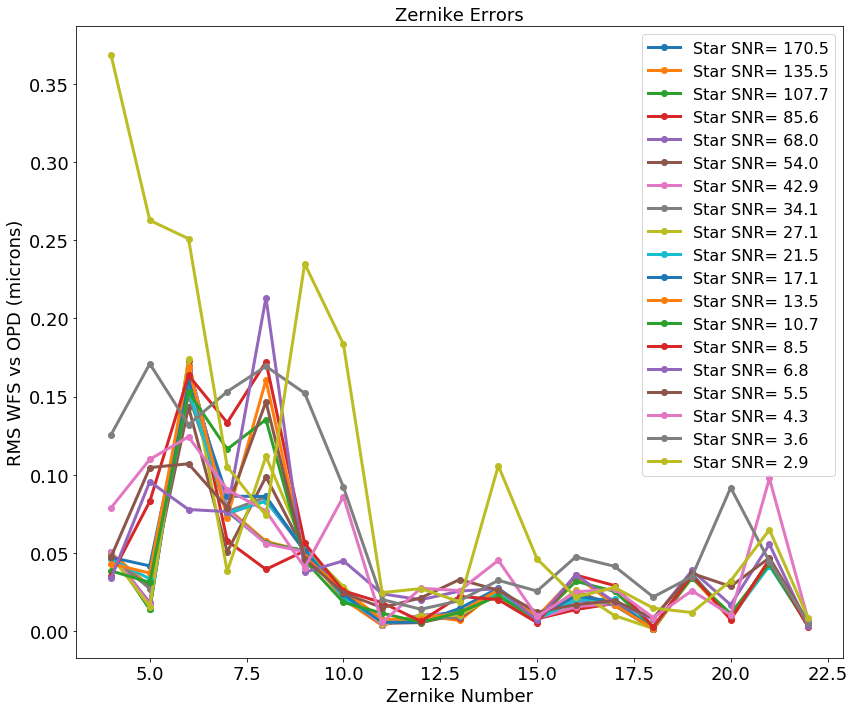

In [13]:
fig = plt.figure(figsize=(12,10))

plot_mag = False

for i in range(len(snr_array)):
    if plot_mag is True:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star Mag= %.1f' % mag_array[i])
    else:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star SNR= %.1f' % snr_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

In [14]:
snr_array[-7], mag_array[-7]

(10.682719, 16.0)

### SNR > 10

If we only include results with a signal-to-noise ratio of greater than 10.0 (g-band magnitude <~ 16.) then the results are very similar except for Zernike Polynomials 7 & 8 (and to a smaller degree 16 & 17). The current lowest magnitude for g-band is set to 16.17 which seems appropriate and approximately equal to an SNR of 10.

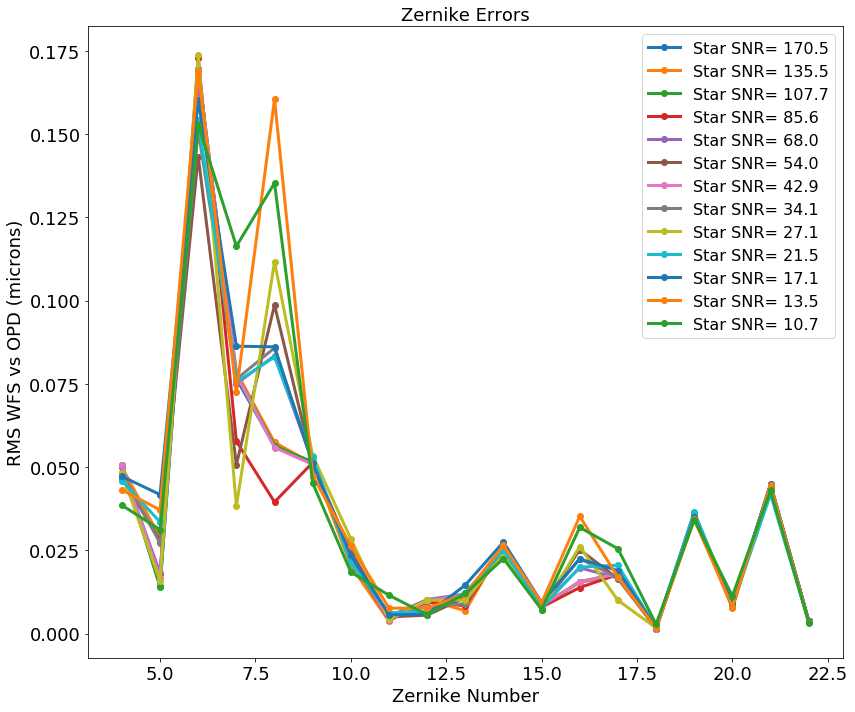

In [15]:
fig = plt.figure(figsize=(12,10))

plot_mag = False

for i in range(len(snr_array)-6):
    if plot_mag is True:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star Mag= %.1f' % mag_array[i])
    else:
        plt.plot(np.arange(19)+4, np.sqrt(np.mean(np.square(zernikeErrors), axis=1)[:, i]), '-o', lw=3, label='Star SNR= %.1f' % snr_array[i])
    plt.xlabel('Zernike Number', size=18)
    plt.ylabel('RMS WFS vs OPD (microns)', size=18)
    plt.xticks(size=18)
    plt.yticks(size=18)
plt.legend(fontsize=16)
plt.title('Zernike Errors', size=18)
    
plt.tight_layout()

#### Generate CCD map of error values

In [16]:
starCat = np.genfromtxt(os.path.join(data_dir, 'starCat.txt'), names=['field', 'ra', 'dec', 'mag'])

In [17]:
starCat['ra'][:3] = starCat['ra'][:3] - 360.

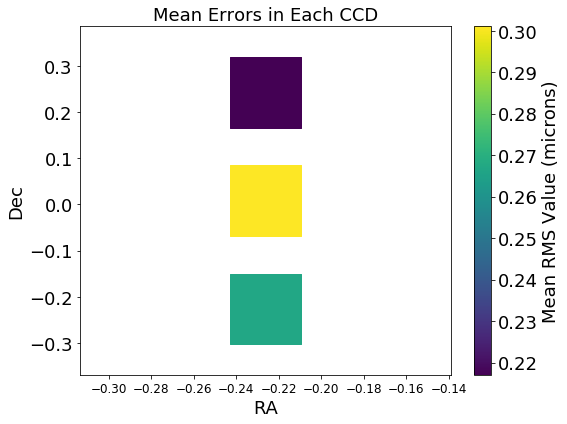

In [18]:
fig = plt.figure(figsize=(8,6))
plt.scatter(starCat['ra'], starCat['dec'], c=np.mean(np.sqrt(np.array(ssrFieldVals)), axis=0), s=5000, marker='s')
plt.xlabel('RA', size=18)
plt.ylabel('Dec', size=18)
plt.xticks(size=12)
plt.yticks(size=18)
cbar = plt.colorbar()
cbar.set_label('Mean RMS Value (microns)', size=18)
cbar.ax.tick_params(labelsize=18)
plt.title('Mean Errors in Each CCD', size=18)
plt.tight_layout()